In [1]:
### Se importan las librerias

import os 
import pandas as pd
import numpy as np
from numpy import exp
import sys
sys.path.append('libreriasTesis')
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.tsa.api import VAR
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from IPython.display import clear_output, Image, display


### Se asingan los paths
pathTesis = os.getcwd()
pathBases = os.path.join(pathTesis,'bases/DatosPrecia/tablaSpline')
pathGraficas = os.path.join(pathTesis,'Graficas')


### Se lee la data y se cambian los nombres
dataTotal = pd.read_csv(os.path.join(pathBases,'dataPrecia.csv'), sep='|',index_col=['Fecha'], parse_dates=True)
vencimientosC = ["tao1","tao2","tao3","tao4","tao5","tao6","tao7","tao8","tao9","tao10","tao11"]
dataTotal.columns = vencimientosC


### Se Asignan los diccionarios corresponientes a la data
observadosY = {'tao2':3/12.0,'tao3':6/12.0, 'tao5':3, 'tao6':5, 'tao8':9, 'tao9':11, 'tao10':13}

cortoPlazoY = {'tao1':1/12.0,'tao2':3/12.0,'tao3':6/12.0,'tao4': 1}
cortoPlazoM = [1/12.0,3/12.0,6/12.0,1]
cortoPlazoV = ["3Y","4Y","5Y",'7Y']

medianoPlazoY = {'tao4':1, 'tao5':3, 'tao6':5, 'tao7':7}
medianoPlazoM = [1,3,5,7]
medianoPlazoV = ['7Y','8Y','9Y','10Y']

largoPlazoY = {'tao7':7, 'tao8':9, 'tao9':11, 'tao10':13,'tao11':15}
largoPlazoM = [7,9,11,13,15]
largoPlazoV = ['10Y','11Y','13Y','15Y','20Y']

innerY = {'tao1':1/12.0, 'tao4':1, 'tao7':7, 'tao11':15}
vec0 = list(np.repeat(0,3))

vencimientos = [1/12.0,3/12.0,6/12.0,1,3,5,7,9,11,13,15]


display(dataTotal.head())
print("dimension:{}".format(dataTotal.shape))

C:\cconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,tao1,tao2,tao3,tao4,tao5,tao6,tao7,tao8,tao9,tao10,tao11
Fecha,,,,,,,,,,,
2013-01-01,2.55,4.18,4.46,4.72,4.99,5.32,5.44,5.55,5.84,5.93,5.691151
2013-01-02,2.33,4.18,4.47,4.73,4.99,5.31,5.46,5.53,5.85,5.89,5.695086
2013-01-03,2.09,4.20,4.46,4.71,4.96,5.29,5.49,5.55,5.83,5.89,5.699017
2013-01-04,2.03,4.24,4.48,4.71,4.97,5.30,5.55,5.57,5.85,5.90,5.702944
2013-01-05,2.03,4.24,4.48,4.71,4.97,5.30,5.55,5.57,5.85,5.90,5.706868


dimension:(1461, 11)


# Se empieza a calulcar por separado los factores corresponientes a los modelos clasicos, segmentado y fuertemente segmentado

# ----------------------------------------------

### Nelson Siegel Clasico

In [2]:
### Los factores del modelo clasico con un lambda de 0.0609

def g(term,lambDa = 0.0609):
    resultado = (1 - exp(-lambDa*term)) / (lambDa*term)
    return resultado


def h(term,lambDa = 0.0609):
    resultado = ((1 - exp(-lambDa*term)) / (lambDa*term)) - exp(-lambDa*term)
    return resultado

In [3]:

### Se calcula el vector para los distinitos vencimientos
gNS = g(np.array(vencimientos))
hNS = h(np.array(vencimientos))
rate = dataTotal

### Se crea un dataframe vacio para luego ir llenandolo con los betas luedo de hacer OLS
betasNS = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a","b","c"])
X = pd.DataFrame({'x2':gNS,'x3':hNS}).values
### Se calculan los betas para cada una de los periodos de la data
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[0],betaPar[1]]
    betasNS.iloc[int(i),:]=betaPar

### Se calcula el yield estimado para cada uno de los periodos    
taoSigmaNelsonSiegelClasico = pd.DataFrame(0, index=np.arange(len(rate)), columns=vencimientosC)
for i in range(len(rate)): 
    taoSigmaNelsonSiegelClasico.iloc[i,:] = betasNS.iloc[i,0] + betasNS.iloc[i,1]*np.array(gNS) + betasNS.iloc[i,2]*np.array(hNS)

# ----------------------------------------------

### Nelson Siegel Segmented

In [4]:
### Se crean las funciones de los factores y sus derivadas de nelson y siegel para el modelo Segmentado suave
def g(term,lambDa = 0.0609):
    resultado = (1 - exp(-lambDa*term)) / (lambDa*term)
    return resultado

def gPD(term,lambDa = 0.0609):
    resultado = (exp(-lambDa*term) * (lambDa*term + 1)) / (lambDa*(term ** 2))
    return resultado

def gSD(term,lambDa = 0.0609):
    resultado = (2 - exp(-lambDa*term) * (((lambDa * term) ** 2) + 2*(lambDa*term + 1))) / (lambDa * (term ** 3))
    return resultado 

def h(term,lambDa = 0.0609):
    resultado = ((1 - exp(-lambDa*term)) / (lambDa*term)) - exp(-lambDa*term)
    return resultado

def hPD(term,lambDa = 0.0609):
    resultado = (exp(-lambDa*term) * (((lambDa*term) ** 2) + (lambDa*term) + 1) - 1) / (lambDa*(term ** 2))
    return resultado

def hSD(term,lambDa = 0.0609):
    resultado = (2 - exp(-lambDa*term)*(((lambDa*term) ** 3) + ((lambDa*term) ** 2) + 2*(lambDa*term + 1))) / (lambDa * (term ** 3))
    return resultado


### Se crea la funcion X que permite retornar los vector de longitud 3 para la creacion de las matrices necesarias 
### del modelo segmentado


def X_function(tao,corte,signo,derivada):
    if derivada == '':
        if signo == '+':
            if corte == 'Corto':
                return [1, g(cortoPlazoY[tao]),h(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [1, g(medianoPlazoY[tao]),h(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [1, g(largoPlazoY[tao]),h(largoPlazoY[tao])]
        elif signo == '-':
            if corte == 'Corto':
                return [-1, -g(cortoPlazoY[tao]),-h(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [-1, -g(medianoPlazoY[tao]),-h(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [-1, -g(largoPlazoY[tao]),-h(largoPlazoY[tao])]
    elif derivada == 'PD':
        if signo == '+':
            if corte == 'Corto':
                return [0, gPD(cortoPlazoY[tao]),hPD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, gPD(medianoPlazoY[tao]),hPD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, gPD(largoPlazoY[tao]),hPD(largoPlazoY[tao])]
        elif signo == '-':
            if corte == 'Corto':
                return [0, -gPD(cortoPlazoY[tao]),-hPD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, -gPD(medianoPlazoY[tao]),-hPD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, -gPD(largoPlazoY[tao]),-hPD(largoPlazoY[tao])]
    elif derivada == 'SD':
        if signo == '+':
            if corte == 'Corto':
                return [0, gSD(cortoPlazoY[tao]),hSD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, gSD(medianoPlazoY[tao]),hSD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, gSD(largoPlazoY[tao]),hSD(largoPlazoY[tao])]
        elif signo == '-':
            if corte == 'Corto':
                return [0, -gSD(cortoPlazoY[tao]),-hSD(cortoPlazoY[tao])]
            elif corte == 'Mediano':
                return [0, -gSD(medianoPlazoY[tao]),-hSD(medianoPlazoY[tao])]
            elif corte == 'Largo':
                return [0, -gSD(largoPlazoY[tao]),-hSD(largoPlazoY[tao])]
            


#### Aplicacion empirica

De aqui en adelante se crean las matrices necesarias w2, w1, R1, R2 para la creacion de Z.
Lo unico que cambia son los vencimientos de w1 y w2 y los valores de los yields

#### Largo Plazo V1

In [5]:
W2 = np.matrix([X_function('tao9' ,'Largo','+',''),
                X_function('tao10' ,'Largo','+',''),
                X_function('tao11','Largo','+','')])


W1 = np.matrix([X_function('tao3','Corto','+','') + vec0,
                vec0                              + X_function('tao5','Mediano','+',''),
                vec0                              + X_function('tao6','Mediano','+','')])


R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])


R1_invertida = np.linalg.inv(R1)


R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])


R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao9','tao10','tao11']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar
    
    
taoSigmaLargoPlazoV1 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao9","tao10","tao11"])
for i in range(len(rate)):  
    taoSigmaLargoPlazoV1.loc[i,'tao9'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaLargoPlazoV1.loc[i,'tao10'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    taoSigmaLargoPlazoV1.loc[i,'tao11'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[2,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[2,2]
    

#### Largo Plazo V2

In [6]:
W2 = np.matrix([X_function('tao7' ,'Largo','+',''),
                X_function('tao8' ,'Largo','+','')])


W1 = np.matrix([X_function('tao3','Corto','+','') + vec0,
                vec0                              + X_function('tao6','Mediano','+','')])



R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])



R1_invertida = np.linalg.inv(R1)

R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])


R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao7','tao8']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar

    
taoSigmaLargoPlazoV2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao7","tao8"])
for i in range(len(rate)):  
    taoSigmaLargoPlazoV2.loc[i,'tao7'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaLargoPlazoV2.loc[i,'tao8'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    
    

#### Mediano Plazo

In [7]:
W2 = np.matrix([X_function('tao7' ,'Largo','+',''),
                X_function('tao8' ,'Largo','+',''),
                X_function('tao9' ,'Largo','+','')])

W1 = np.matrix([X_function('tao3','Corto','+','') + vec0,
                vec0                              + X_function('tao5','Mediano','+',''),
                vec0                              + X_function('tao6','Mediano','+','')])


R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])



R1_invertida = np.linalg.inv(R1)


R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])

R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao3','tao5','tao6']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar

    
taoSigmaMedianoPlazo = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao3","tao5","tao6"])
for i in range(len(rate)):  
    taoSigmaMedianoPlazo.loc[i,'tao3'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaMedianoPlazo.loc[i,'tao5'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    taoSigmaMedianoPlazo.loc[i,'tao6'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[2,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[2,2]

#### Corto Plazo

In [8]:
W2 = np.matrix([X_function('tao7' ,'Largo','+',''),
                X_function('tao8' ,'Largo','+',''),
                X_function('tao9' ,'Largo','+','')])


W1 = np.matrix([X_function('tao1','Corto','+','') + vec0,
                X_function('tao2','Corto','+','') + vec0,
                vec0                              + X_function('tao4','Mediano','+','')])



R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])



R1_invertida = np.linalg.inv(R1)


R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])


R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao1','tao2','tao4']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar

    
taoSigmaCortoPlazo = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao1","tao2","tao4"])
for i in range(len(rate)):  
    taoSigmaCortoPlazo.loc[i,'tao1'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaCortoPlazo.loc[i,'tao2'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    taoSigmaCortoPlazo.loc[i,'tao4'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[2,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[2,2]
    

#### Union Plazos

In [9]:
### Se unen todos los yields de largo plazo v1,v2, mediano plazo y corto plazo
taoSigmaNelsonSiegelSegmentado = taoSigmaCortoPlazo.join(taoSigmaMedianoPlazo).join(taoSigmaLargoPlazoV1).join(taoSigmaLargoPlazoV2)[vencimientosC]

# ----------------------------------------------

## Nelson Siegel Strongly Segmented

In [10]:
### Se crean las funciones de los factores y sus derivadas de nelson y siegel para el modelo Segmentado Fuertemente
### Segmentado

def g(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (1 - exp(-lambDa*A)) / (lambDa*A)
    return resultado

def gPD(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (exp(-lambDa*A) * (lambDa*A + 1)) / (lambDa*(A ** 2))
    return resultado

def gSD(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (2 - exp(-lambDa*A) * (((lambDa * A) ** 2) + 2*(lambDa*A + 1))) / (lambDa * (A ** 3))
    return resultado 

def h(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = ((1 - exp(-lambDa*A)) / (lambDa*A)) - exp(-lambDa*A)
    return resultado

def hPD(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (exp(-lambDa*A) * (((lambDa*A) ** 2) + (lambDa*A) + 1) - 1) / (lambDa*(A ** 2))
    return resultado

def hSD(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (2 - exp(-lambDa*A)*(((lambDa*A) ** 3) + ((lambDa*A) ** 2) + 2*(lambDa*A + 1))) / (lambDa * (A ** 3))
    return resultado


### Se crea la funcion X que permite retornar los vector de longitud 3 para la creacion de las matrices necesarias 
### del modelo fuertemente segmentado

def X_function(tao,corte,signo,derivada):
    if derivada == '':
        if signo == '+':
            if corte == 'Corto':
                taoImenos = 'tao1'
                return [1, g(cortoPlazoY[tao],cortoPlazoY[taoImenos]),h(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                taoImenos = 'tao4'
                return [1, g(medianoPlazoY[tao],medianoPlazoY[taoImenos]),h(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                taoImenos = 'tao7'
                return [1, g(largoPlazoY[tao],largoPlazoY[taoImenos]),h(largoPlazoY[tao],largoPlazoY[taoImenos])]
        elif signo == '-':
            if corte == 'Corto':
                taoImenos = 'tao1'
                return [-1, -g(cortoPlazoY[tao],cortoPlazoY[taoImenos]),-h(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                taoImenos = 'tao4'
                return [-1, -g(medianoPlazoY[tao],medianoPlazoY[taoImenos]),-h(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                taoImenos = 'tao7'
                return [-1, -g(largoPlazoY[tao],largoPlazoY[taoImenos]),-h(largoPlazoY[tao],largoPlazoY[taoImenos])]
    elif derivada == 'PD':
        if signo == '+':
            if corte == 'Corto':
                taoImenos = 'tao1'
                return [0, gPD(cortoPlazoY[tao],cortoPlazoY[taoImenos]),hPD(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                taoImenos = 'tao4'
                return [0, gPD(medianoPlazoY[tao],medianoPlazoY[taoImenos]),hPD(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                taoImenos = 'tao7'
                return [0, gPD(largoPlazoY[tao],largoPlazoY[taoImenos]),hPD(largoPlazoY[tao],largoPlazoY[taoImenos])]
        elif signo == '-':
            if corte == 'Corto':
                taoImenos = 'tao1'
                return [0, -gPD(cortoPlazoY[tao],cortoPlazoY[taoImenos]),-hPD(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                taoImenos = 'tao4'
                return [0, -gPD(medianoPlazoY[tao],medianoPlazoY[taoImenos]),-hPD(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                taoImenos = 'tao7'
                return [0, -gPD(largoPlazoY[tao],largoPlazoY[taoImenos]),-hPD(largoPlazoY[tao],largoPlazoY[taoImenos])]
    elif derivada == 'SD':
        if signo == '+':
            if corte == 'Corto':
                taoImenos = 'tao1'
                return [0, gSD(cortoPlazoY[tao],cortoPlazoY[taoImenos]),hSD(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                taoImenos = 'tao4'
                return [0, gSD(medianoPlazoY[tao],medianoPlazoY[taoImenos]),hSD(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                taoImenos = 'tao7'
                return [0, gSD(largoPlazoY[tao],largoPlazoY[taoImenos]),hSD(largoPlazoY[tao],largoPlazoY[taoImenos])]
        elif signo == '-':
            if corte == 'Corto':
                taoImenos = 'tao1'
                return [0, -gSD(cortoPlazoY[tao],cortoPlazoY[taoImenos]),-hSD(cortoPlazoY[tao],cortoPlazoY[taoImenos])]
            elif corte == 'Mediano':
                taoImenos = 'tao4'
                return [0, -gSD(medianoPlazoY[tao],medianoPlazoY[taoImenos]),-hSD(medianoPlazoY[tao],medianoPlazoY[taoImenos])]
            elif corte == 'Largo':
                taoImenos = 'tao7'
                return [0, -gSD(largoPlazoY[tao],largoPlazoY[taoImenos]),-hSD(largoPlazoY[tao],largoPlazoY[taoImenos])]

#### Aplicacion empirica

De aqui en adelante se crean las matrices necesarias w2, w1, R1, R2 para la creacion de Z.
Lo unico que cambia son los vencimientos de w1 y w2 y los valores de los yields

#### Largo Plazo V1

In [11]:
W2 = np.matrix([X_function('tao9' ,'Largo','+',''),
                X_function('tao10' ,'Largo','+',''),
                X_function('tao11','Largo','+','')])


W1 = np.matrix([X_function('tao3','Corto','+','') + vec0,
                vec0                              + X_function('tao5','Mediano','+',''),
                vec0                              + X_function('tao6','Mediano','+','')])


R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])


R1_invertida = np.linalg.inv(R1)


R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])


R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao9','tao10','tao11']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar
    
    
taoSigmaLargoPlazoV1Str = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao9","tao10","tao11"])
for i in range(len(rate)):  
    taoSigmaLargoPlazoV1Str.loc[i,'tao9'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaLargoPlazoV1Str.loc[i,'tao10'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    taoSigmaLargoPlazoV1Str.loc[i,'tao11'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[2,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[2,2]
    

#### Largo Plazo V2

In [12]:
W2 = np.matrix([X_function('tao7' ,'Largo','+',''),
                X_function('tao8' ,'Largo','+','')])


W1 = np.matrix([X_function('tao3','Corto','+','') + vec0,
                vec0                              + X_function('tao6','Mediano','+','')])



R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])



R1_invertida = np.linalg.inv(R1)

R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])


R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao7','tao8']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar

    
taoSigmaLargoPlazoV2Str = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao7","tao8"])
for i in range(len(rate)):  
    taoSigmaLargoPlazoV2Str.loc[i,'tao7'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaLargoPlazoV2Str.loc[i,'tao8'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    
    

#### Mediano Plazo

In [13]:
W2 = np.matrix([X_function('tao7' ,'Largo','+',''),
                X_function('tao8' ,'Largo','+',''),
                X_function('tao9' ,'Largo','+','')])

W1 = np.matrix([X_function('tao3','Corto','+','') + vec0,
                vec0                              + X_function('tao5','Mediano','+',''),
                vec0                              + X_function('tao6','Mediano','+','')])


R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])



R1_invertida = np.linalg.inv(R1)


R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])

R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao3','tao5','tao6']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar

    
taoSigmaMedianoPlazoStr = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao3","tao5","tao6"])
for i in range(len(rate)):  
    taoSigmaMedianoPlazoStr.loc[i,'tao3'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaMedianoPlazoStr.loc[i,'tao5'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    taoSigmaMedianoPlazoStr.loc[i,'tao6'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[2,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[2,2]

#### Corto Plazo

In [14]:
W2 = np.matrix([X_function('tao7' ,'Largo','+',''),
                X_function('tao8' ,'Largo','+',''),
                X_function('tao9' ,'Largo','+','')])


W1 = np.matrix([X_function('tao1','Corto','+','') + vec0,
                X_function('tao2','Corto','+','') + vec0,
                vec0                              + X_function('tao4','Mediano','+','')])



R1 =  np.matrix([X_function('tao4','Corto','+','')   + X_function('tao4','Mediano','-',''),
                 vec0                                + X_function('tao7','Mediano','+',''),
                 X_function('tao4','Corto','+','PD') + X_function('tao4','Mediano','-','PD'),
                 vec0                                + X_function('tao7','Mediano','+','PD'),
                 X_function('tao4','Corto','+','SD') + X_function('tao4','Mediano','-','SD'),
                 vec0                                + X_function('tao7','Mediano','+','SD')])



R1_invertida = np.linalg.inv(R1)


R2 = np.matrix([vec0,
                X_function('tao7','Largo','-',''),
                vec0,
                X_function('tao7','Largo','-','PD'),
                vec0,
                X_function('tao7','Largo','-','SD'),])


R2_invertida = np.linalg.pinv(R2)



Z = W2 - (W1 * R1_invertida) * R2

X = Z


rate = dataTotal.loc[:,['tao1','tao2','tao4']]
sigma2 = pd.DataFrame(0, index=np.arange(len(rate)), columns=["a_NSSegSuLP","b_NSSegSuLP","c_NSSegSuLP"])
for i in range(len(rate)):
    lm = LinearRegression()
    y = rate.iloc[i,:]
    lm.fit(X,y)
    betaPar = lm.coef_
    betaPar = [lm.intercept_.tolist(),betaPar[1],betaPar[2]]
    sigma2.iloc[int(i),:]=betaPar

    
taoSigmaCortoPlazoStr = pd.DataFrame(0, index=np.arange(len(rate)), columns=["tao1","tao2","tao4"])
for i in range(len(rate)):  
    taoSigmaCortoPlazoStr.loc[i,'tao1'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[0,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[0,2]
    taoSigmaCortoPlazoStr.loc[i,'tao2'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[1,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[1,2]
    taoSigmaCortoPlazoStr.loc[i,'tao4'] = sigma2.loc[i,'a_NSSegSuLP'] + sigma2.loc[i,'b_NSSegSuLP']*Z[2,1] + sigma2.loc[i,'c_NSSegSuLP']*Z[2,2]
    

#### Union de Plazos

In [15]:
### Se unen todos los yields de largo plazo v1,v2, mediano plazo y corto plazo
taoSigmaNelsonSiegelSegmentadoStr = taoSigmaCortoPlazoStr.join(taoSigmaMedianoPlazoStr).join(taoSigmaLargoPlazoV1Str).join(taoSigmaLargoPlazoV2Str)[vencimientosC]

# ----------------------------------------------

# Graficas

### Loadings Segmentado

C:\cconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\cconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


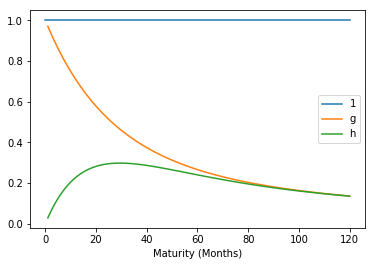

In [16]:
def g(term,lambDa = 0.0609):
    resultado = (1 - exp(-lambDa*term)) / (lambDa*term)
    return resultado


def h(term,lambDa = 0.0609):
    resultado = ((1 - exp(-lambDa*term)) / (lambDa*term)) - exp(-lambDa*term)
    return resultado

maturityPaper = np.array(range(0,121))
gValor = g(maturityPaper)
hValor = h(maturityPaper)
vec1 = list(np.repeat(1,len(maturityPaper)))
grafica2 = pd.DataFrame.from_dict({'1':vec1,'g':gValor,'h':hValor})
grafica2.plot()
plt.xlabel('Maturity (Months)')
plt.savefig(os.path.join(pathGraficas,'FactorLoadingsNS3'))
plt.show()

### Loadings Segmentado Fuertemente

C:\cconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\cconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


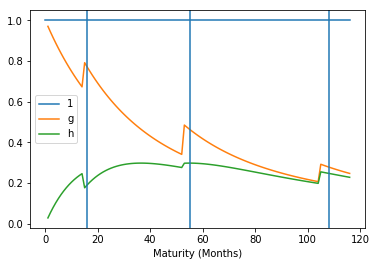

In [17]:
def g(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = (1 - exp(-lambDa*A)) / (lambDa*A)
    return resultado

def h(term,termImenos,lambDa = 0.0609, p = 0.5):
    A = term - termImenos*(1-p)
    resultado = ((1 - exp(-lambDa*A)) / (lambDa*A)) - exp(-lambDa*A)
    return resultado

maturityPaper1 = np.array(range(0,15))
maturityPaper2 = np.array(range(16,54))
maturityPaper3 = np.array(range(55,107))
maturityPaper4 = np.array(range(108,120))

gValor1 = g(maturityPaper1,0)
gValor2 = g(maturityPaper2,16)
gValor3 = g(maturityPaper3,55)
gValor4 = g(maturityPaper4,108)
gValor = np.append(np.append(gValor1,gValor2),np.append(gValor3,gValor4))

hValor1 = h(maturityPaper1,0)
hValor2 = h(maturityPaper2,16)
hValor3 = h(maturityPaper3,55)
hValor4 = h(maturityPaper4,108)
hValor = np.append(np.append(hValor1,hValor2),np.append(hValor3,hValor4))

vec1 = list(np.repeat(1,len(hValor)))

grafica2 = pd.DataFrame.from_dict({'1':vec1,'g':gValor,'h':hValor})
grafica2.plot()
plt.axvline(x=16)
plt.axvline(x=55)
plt.axvline(x=108)
plt.xlabel('Maturity (Months)')
plt.savefig(os.path.join(pathGraficas,'FactorLoadingsNS3Strong'))
plt.show()

### Modelo Segmentado

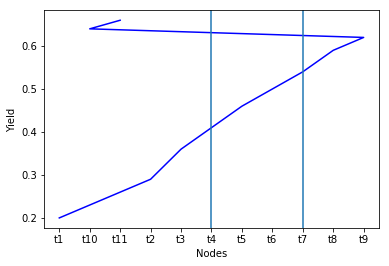

In [18]:
plt.plot(['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11'],
[0.2,0.29,0.36,0.41,0.46,0.5,0.54,0.59,0.62,0.64,0.66],'b')
plt.xlabel('Nodes')
plt.ylabel('Yield')
plt.axvline(x='t4')
plt.axvline(x='t7')
plt.savefig(os.path.join(pathGraficas,'nodos'))
plt.show()

### Grafica de todos los yields

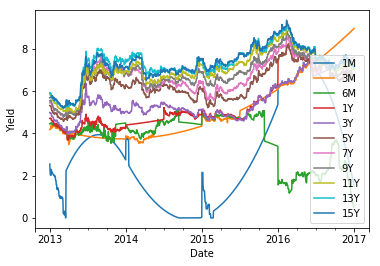

In [19]:
dataTotal.index.names = ['Date']
dataTotal.columns =['1M','3M','6M','1Y','3Y','5Y','7Y','9Y','11Y','13Y','15Y']
dataTotal.plot()
plt.ylabel('Yield')
plt.savefig(os.path.join(pathGraficas,'yields'))
plt.show()

### Grafica de todos los yields mayor o igual a 1 an\o

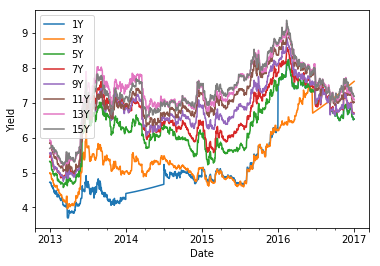

In [20]:
dataTotal[['1Y','3Y','5Y','7Y','9Y','11Y','13Y','15Y']].plot()
plt.ylabel('Yield')
plt.savefig(os.path.join(pathGraficas,'yieldsmayor1'))
plt.show()

### Grafica de todos los yields menores a 1 an\o

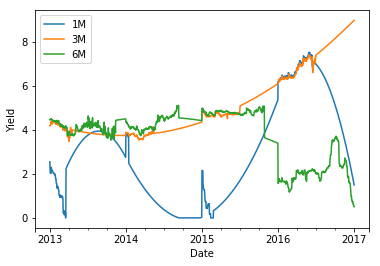

In [21]:
dataTotal[['1M','3M','6M']].plot()
plt.ylabel('Yield')
plt.savefig(os.path.join(pathGraficas,'yieldsmenor1'))
plt.show()

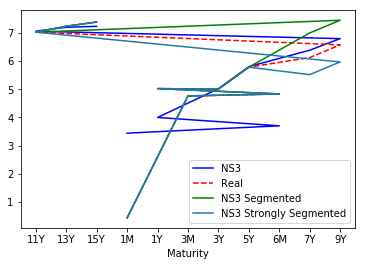

In [22]:
i = 800
plt.plot(['1M','3M','6M','1Y','3Y','5Y','7Y','9Y','11Y','13Y','15Y'],
         taoSigmaNelsonSiegelClasico.iloc[i,:],'b',
         ['1M','3M','6M','1Y','3Y','5Y','7Y','9Y','11Y','13Y','15Y'],
         dataTotal.iloc[i,:],'r--',
        ['1M','3M','6M','1Y','3Y','5Y','7Y','9Y','11Y','13Y','15Y'],
        taoSigmaNelsonSiegelSegmentado.iloc[i,:],'g',
        ['1M','3M','6M','1Y','3Y','5Y','7Y','9Y','11Y','13Y','15Y'],
        taoSigmaNelsonSiegelSegmentadoStr.iloc[i,:])
plt.xlabel('Maturity')
plt.legend(['NS3','Real','NS3 Segmented','NS3 Strongly Segmented'])
plt.savefig(os.path.join(pathGraficas,'ComparisonModels'))
plt.show()



## MSE entre NS3 y NS3 Segmented Fitted Yields

In [42]:
NS3 = (pd.DataFrame(np.sqrt((taoSigmaNelsonSiegelClasico.values - dataTotal.values)**2)).apply(np.mean,0)*100).values

In [43]:
NS3_Segmented = (pd.DataFrame(np.sqrt((taoSigmaNelsonSiegelSegmentado.values - dataTotal.values)**2)).apply(np.mean,0)*100).values

In [44]:
NS3_Segmented_Strongly = (pd.DataFrame(np.sqrt((taoSigmaNelsonSiegelSegmentadoStr.values - dataTotal.values)**2)).apply(np.mean,0)*100).values

In [45]:
MSE_Comparativo = pd.DataFrame({'NS3':NS3,'NS3_Segmented':NS3_Segmented,'NS3_Segmented_Strongly':NS3_Segmented_Strongly},index=['1M','3M','6M','1Y','3Y','5Y','7Y','9Y','11Y','13Y','15Y'])

In [46]:
MSE_Comparativo = MSE_Comparativo.reset_index()

In [47]:
MSE_Comparativo.columns = ['Maturity', 'NS3', 'NS3 Segmented','NS3 Stronly Segmented'] 

In [48]:
MSE_Comparativo.to_latex(index=False,bold_rows=True ,buf=os.path.join(pathGraficas,'tablaInSample'))